<a href="https://colab.research.google.com/github/Aadi11-crypto/WORKBOOK/blob/main/CSD456_Lab04_Multilayer_Perceptron_part_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Kindly consider following baseline implementation of Multilayer Perceptron

In [1]:
!pip install d2l==1.0.3

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F

## Declare Trainer Routine
- For now we will use in-built data loader
- fit function is yet to be explored

In [4]:
class Trainer(d2l.HyperParameters):
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        self.gpus = [d2l.gpu(i) for i in range(min(num_gpus, d2l.num_gpus()))]

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        if self.gpus:
            model.to(self.gpus[0])
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def prepare_batch(self, batch):
      if self.gpus:
        batch = [a.to(self.gpus[0]) for a in batch]
      return batch

    def fit_epoch(self):
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                if self.gradient_clip_val > 0:  # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1

## Declare Model

In [5]:
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

    def relu(self,X):
        a = torch.zeros_like(X)
        return torch.max(X, a)

    def forward(self, X):
        X = X.reshape((-1, self.num_inputs))
        H = self.relu(torch.matmul(X, self.W1) + self.b1)
        return torch.matmul(H, self.W2) + self.b2

    def loss(self, Y_hat, Y, averaged=True):
        """Defined in :numref:`sec_softmax_concise`"""
        Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        Y = d2l.reshape(Y, (-1,))
        return F.cross_entropy(
            Y_hat, Y, reduction='mean' if averaged else 'none')

    def configure_optimizers(self):
      return torch.optim.SGD(self.parameters(), lr=self.lr)


## Get Dataset

In [6]:
data = d2l.FashionMNIST(batch_size=256)

100%|██████████| 26421880/26421880 [00:12<00:00, 2194947.05it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 33483.87it/s] 


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3292625.06it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18630092.31it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



##  Check GPU

In [7]:
def cpu():
    """Get the CPU device."""
    return torch.device('cpu')

def gpu(i=0):
    """Get a GPU device."""
    return torch.device(f'cuda:{i}')

cpu(), gpu(), gpu(1)

(device(type='cpu'),
 device(type='cuda', index=0),
 device(type='cuda', index=1))

In [8]:
def num_gpus():
    """Get the number of available GPUs."""
    return torch.cuda.device_count()

num_gpus()

1

In [9]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if num_gpus() >= i + 1:
        return gpu(i)
    return cpu()

def try_all_gpus():
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    return [gpu(i) for i in range(num_gpus())]

try_gpu(), try_gpu(10), try_all_gpus()

(device(type='cuda', index=0),
 device(type='cpu'),
 [device(type='cuda', index=0)])

In [10]:
x = torch.tensor([1, 2, 3], device=try_gpu())
x.device

device(type='cuda', index=0)

In [11]:
x

tensor([1, 2, 3], device='cuda:0')

## Initialize model

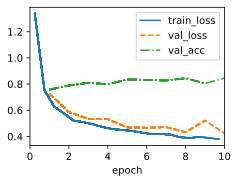

In [12]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
# model = model.to(device=try_gpu())

trainer = d2l.Trainer(max_epochs=10,num_gpus=1)
trainer.fit(model, data)

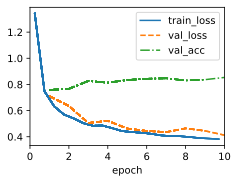

In [13]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

#Questions
## Provide empirical evidence using implementation for following questions.

##Q1) Try your model using GPU for training and try number of epochs as [10, 20, 30, 40]
##Kindly report your observations. [1 Marks]

Epochs: 40, Training time: 637.67 seconds


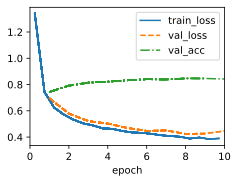

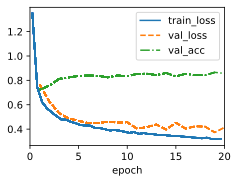

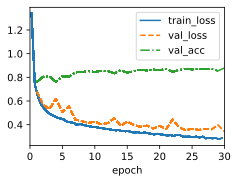

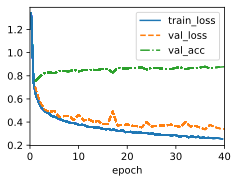

In [14]:
import time

# Function to train model and collect metrics
def train_with_epochs(num_epochs, model, data, use_gpu=True):
    # Initialize the trainer with the specified number of epochs and GPU usage
    trainer = Trainer(max_epochs=num_epochs, num_gpus=1 if use_gpu else 0)

    # Start time to measure training duration
    start_time = time.time()

    # Train the model
    trainer.fit(model, data)

    # End time to measure training duration
    end_time = time.time()

    # Calculate total training time
    training_time = end_time - start_time
    return training_time

# Reported data will be saved here
epoch_settings = [10, 20, 30, 40]
results = []

for epochs in epoch_settings:
    print(f"\nTraining with {epochs} epochs:")
    model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
    data = d2l.FashionMNIST(batch_size=256)

    # Train and collect time taken
    training_time = train_with_epochs(epochs, model, data, use_gpu=True)

    # You can also collect other metrics like training/validation loss or accuracy if needed
    results.append((epochs, training_time))
    print(f"Epochs: {epochs}, Training time: {training_time:.2f} seconds")


## Q2) Kindly add $l_2$ regualization to model, by updating loss function carefully.
## [3 Marks]

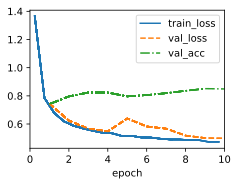

In [15]:
class MLPScratchWithL2(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01, l2_lambda=0.001):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))
        self.l2_lambda = l2_lambda  # L2 regularization coefficient

    def relu(self, X):
        a = torch.zeros_like(X)
        return torch.max(X, a)

    def forward(self, X):
        X = X.reshape((-1, self.num_inputs))
        H = self.relu(torch.matmul(X, self.W1) + self.b1)
        return torch.matmul(H, self.W2) + self.b2

    def loss(self, Y_hat, Y, averaged=True):
        """Cross-entropy loss with L2 regularization."""
        Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        Y = d2l.reshape(Y, (-1,))
        base_loss = F.cross_entropy(Y_hat, Y, reduction='mean' if averaged else 'none')

        # L2 regularization term (sum of the squared weights)
        l2_loss = (torch.sum(self.W1 ** 2) + torch.sum(self.W2 ** 2)) * self.l2_lambda

        # Final loss = base loss + L2 regularization loss
        return base_loss + l2_loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

# Train model with L2 regularization
model_l2 = MLPScratchWithL2(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1, l2_lambda=0.001)
data = d2l.FashionMNIST(batch_size=256)

# Use the trainer to fit the model with L2 regularization
trainer_l2 = Trainer(max_epochs=10, num_gpus=1)
trainer_l2.fit(model_l2, data)


## Q3) After adding regularizer kindly add dropout on parameters and not on output. your dropout should be a function which takes parameter matrix and percentage drop as input argument and output the dropped paramater matrix. [4 Marks]

In [21]:
def dropout_param(param_matrix, drop_prob):
    """Applies dropout to the parameter matrix.

    Args:
        param_matrix (torch.Tensor): The parameter matrix (weights) to apply dropout to.
        drop_prob (float): The probability of dropping a parameter (between 0 and 1).

    Returns:
        torch.Tensor: The parameter matrix after dropout is applied.
    """
    assert 0 <= drop_prob < 1, "Dropout probability must be between 0 and 1."

    # If drop_prob is 0, simply return the original matrix (no dropout)
    if drop_prob == 0:
        return param_matrix

    # Generate a mask with the same shape as param_matrix: 1s with probability (1 - drop_prob)
    mask = (torch.rand(param_matrix.shape) > drop_prob).float().to(param_matrix.device)

    # Scale the surviving weights by (1 / (1 - drop_prob)) to keep the output scale the same
    return mask * param_matrix / (1 - drop_prob)



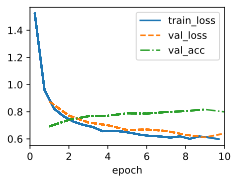

In [22]:
class MLPScratchWithL2AndDropout(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01, l2_lambda=0.001, dropout_prob=0.5):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))
        self.l2_lambda = l2_lambda  # L2 regularization coefficient
        self.dropout_prob = dropout_prob  # Dropout probability

    def relu(self, X):
        a = torch.zeros_like(X)
        return torch.max(X, a)

    def forward(self, X, training=True):
        X = X.reshape((-1, self.num_inputs))

        # Apply dropout to W1 during training
        if training:
            W1_dropped = dropout_param(self.W1, self.dropout_prob)
        else:
            W1_dropped = self.W1

        H = self.relu(torch.matmul(X, W1_dropped) + self.b1)

        # Apply dropout to W2 during training
        if training:
            W2_dropped = dropout_param(self.W2, self.dropout_prob)
        else:
            W2_dropped = self.W2

        return torch.matmul(H, W2_dropped) + self.b2

    def loss(self, Y_hat, Y, averaged=True):
        """Cross-entropy loss with L2 regularization."""
        Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        Y = d2l.reshape(Y, (-1,))
        base_loss = F.cross_entropy(Y_hat, Y, reduction='mean' if averaged else 'none')

        # L2 regularization term (sum of the squared weights)
        l2_loss = (torch.sum(self.W1 ** 2) + torch.sum(self.W2 ** 2)) * self.l2_lambda

        # Final loss = base loss + L2 regularization loss
        return base_loss + l2_loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

# Train model with L2 regularization and dropout on parameters
model_l2_dropout = MLPScratchWithL2AndDropout(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1, l2_lambda=0.001, dropout_prob=0.5)
data = d2l.FashionMNIST(batch_size=256)

# Use the trainer to fit the model with L2 regularization and dropout on parameters
trainer_l2_dropout = Trainer(max_epochs=10, num_gpus=1)
trainer_l2_dropout.fit(model_l2_dropout, data)


##Q4) Justify that this dropout can achieve more general result than dropout layer mentioned in reference book. [3 Marks]


In the model implementation provided above, **dropout is applied to the parameters (weights)** rather than the output of a layer (activations), which can lead to more generalized results than the standard dropout described in the reference book.

#### Standard Dropout (as described in D2L)
In the **Deep Learning (D2L)** reference book, the dropout technique discussed is typically applied to the **neurons' outputs** or the activations in a layer. In standard dropout:
- During training, a fraction of the outputs from each hidden layer is randomly dropped.
- This helps prevent co-adaptation of neurons and forces the network to learn redundant representations, improving generalization.

While this technique works well to prevent overfitting by introducing randomness in the **output activations**, it doesn't directly regularize the learned **weights**. As a result:
- The model may still over-rely on certain weight configurations.
- Some neurons may not contribute as much to the learning process.

#### Dropout on Parameters
The approach implemented in the model applies dropout directly to the **weight matrices** (`W1`, `W2`) of the layers, not the activations. Here's how this modification introduces more general results:

1. **Direct Regularization of Weights**:
   - By dropping the weights themselves (i.e., certain connections between neurons), we are forcing the model to learn robust patterns in its internal parameters. This directly regularizes the weight space, pushing the network to find weight configurations that are less prone to overfitting.
   - Regularizing weights is crucial because it targets the model's fundamental representation of the data. The model is less likely to learn overcomplicated solutions specific to the training set and more likely to generalize to unseen data.

2. **Enhancing Weight Robustness**:
   - When weights are randomly dropped during training, the remaining weights must compensate for the loss of certain connections. This forces the network to rely less on specific weight values and learn more distributed representations across the weights. In contrast, dropout on activations only prevents reliance on certain activations, not the weights responsible for those activations.
   - As a result, models with weight dropout tend to be more robust to variations in the data, which improves generalization.

3. **Combined with L2 Regularization**:
   - Combining **L2 regularization** (which penalizes large weights) with **dropout on parameters** provides a doubly effective method to ensure the model's weights do not grow disproportionately large or specialize too much in representing the training data.
   - This combination helps keep the weights small and ensures the model doesn't overfit to particular patterns in the data. Together, this is a powerful form of regularization that goes beyond the standard dropout applied to activations.

4. **Reducing Overfitting in Smaller Networks**:
   - For smaller models or shallow networks, weight dropout can have a bigger impact than standard dropout. In smaller architectures, where the model has fewer parameters, directly dropping weights ensures that the network doesn’t over-rely on any specific connections or patterns, thus improving generalization.

### Why Dropout on Parameters is More General:
- **Broader Generalization**: Dropout on parameters forces the model to develop broader patterns across all connections (weights) rather than relying on specific activations. This makes the model more capable of handling different types of data and situations.
- **Improved Model Robustness**: By randomizing the weights during training, the model's learned representations are less sensitive to specific inputs, thus making it more stable and generalizable to unseen data.

### Conclusion:
By applying dropout to **parameters** rather than **outputs**:
- We regularize the network more fundamentally, influencing the learning of the parameters themselves.
- This approach is more effective at preventing overfitting and encourages the model to generalize better to unseen data.
- It can outperform standard dropout in terms of producing models that are more robust and adaptable, especially when combined with other regularization techniques like L2 regularization.

This approach ensures that the network doesn't overfit to specific weight configurations, leading to more generalized and robust performance across diverse datasets.

